In [ ]:
# load autoencoder and cluster patches of the latent space

In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch

from sklearn.mixture import GaussianMixture

from particle_detection.data.data_pipeline import create_dataloaders
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.utils.model_utils import load_model
from particle_detection.clustering.cluster_visualization import process_and_visualize_clusters, visualize_binary_clusters, compare_original_and_clusters
from particle_detection.utils.pca_preprocessing import apply_pca, plot_explained_variance

In [3]:
data_dir = "../data"
#data_dir = "/home/blah-buttery/nanoparticles/images/normal" # gpu ws 
#dataset_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook
image_size = (2048, 2048)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [4]:
model_path = "../saved_models/ae_1000_epochs.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = create_autoencoder().to(device)
autoencoder = load_model(autoencoder, model_path, device=device)
autoencoder.eval()

print("Model loaded successfully.")

Loading model from: ../saved_models/ae_1000_epochs.pth
Model loaded successfully from ../saved_models/ae_1000_epochs.pth.
Model loaded successfully.


In [5]:
def extract_patches(image, patch_size=16):
    patches = []
    _, height, width = image.shape
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:  # Only full patches
                patches.append(patch)
    return patches

In [6]:
def extract_latent_representations_for_patches(data_loader, patch_size=16):
    autoencoder.eval()
    latent_representations = []
    patch_coordinates = []
    with torch.no_grad():
        for img in data_loader:
            img = img[0].to(device) 
            patches = extract_patches(img, patch_size)
            for idx, patch in enumerate(patches):
                patch = patch.unsqueeze(0).to(device)  # add batch dimension
                latent_vector = autoencoder.encode(patch)
                latent_representations.append(latent_vector.cpu().numpy())
                patch_coordinates.append((idx, img.shape[1], img.shape[2]))  # track position for reconstruction
    return np.concatenate(latent_representations), patch_coordinates

In [ ]:
#optimization

import numpy as np
import matplotlib.pyplot as plt

def visualize_clusters(img, patch_coordinates, cluster_labels, patch_size=16):
    height, width = img.shape[-2], img.shape[-1]  # Ensure it works with channel-first and channel-last formats
    clustered_image = np.zeros((height, width))
    
    for (i, j), cluster in zip(patch_coordinates, cluster_labels):
        clustered_image[i:i + patch_size, j:j + patch_size] = cluster
    
    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap="viridis")
    plt.colorbar()
    plt.title("Nanoparticle Clusters")
    plt.show()

    return clustered_image

In [7]:
def visualize_clusters(img, patch_coordinates, cluster_labels, patch_size=16):
    height, width = img.shape[1], img.shape[2]
    clustered_image = np.zeros((height, width))
    num_patches_w = width // patch_size  # Number of patches per row

    for idx, (coord, h, w) in enumerate(patch_coordinates):
        # Calculate row and column index based on the patch index and image width
        i = (coord // num_patches_w) * patch_size
        j = (coord % num_patches_w) * patch_size
        clustered_image[i:i + patch_size, j:j + patch_size] = cluster_labels[idx]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap="viridis")
    plt.colorbar()
    plt.title("Nanoparticle Clusters")
    plt.show()
    return clustered_image

In [8]:
def plot_cluster_contours(sample_img, binary_cluster_labels_grid, cluster_id=None, title="Cluster Contours"):
    """
    Visualize a specific cluster (or all) by overlaying contours on the original image.

    Args:
        sample_img (torch.Tensor): Image tensor with shape [B, C, H, W] or [C, H, W].
        binary_cluster_labels_grid (np.ndarray): Cluster labels grid with shape [H, W].
        cluster_id (int, optional): The specific cluster ID to visualize. If None, all clusters are visualized.
        title (str): Title for the visualization.
    """
    if sample_img.shape[0] == 3:  # If RGB, convert to grayscale
        image_np = sample_img.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, 3)
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    else:
        image_np = sample_img[0].cpu().numpy()  # Take first channel for grayscale

    # Normalize grayscale image for better visualization
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min()) * 255
    image_np = image_np.astype(np.uint8)

    # Resize binary mask to match original image size
    resized_binary_mask = cv2.resize(binary_cluster_labels_grid, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # If a specific cluster is selected, create a mask for only that cluster
    if cluster_id is not None:
        mask = (resized_binary_mask == cluster_id).astype(np.uint8)  # Keep only the selected cluster
    else:
        mask = (resized_binary_mask > 0).astype(np.uint8)  # Show all clusters if no ID is provided

    # Extract contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert grayscale image to BGR for colored overlay
    overlay = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

    # Draw contours in green
    cv2.drawContours(overlay, contours, -1, (255, 0, 0), 1)

    # Display the overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Cluster {cluster_id}" if cluster_id is not None else "All Clusters")
    plt.axis("off")
    plt.show()

In [5]:
def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [11]:
patch_size=16

In [12]:
latent_representations, patch_coordinates = extract_latent_representations_for_patches(test_loader, patch_size=patch_size)

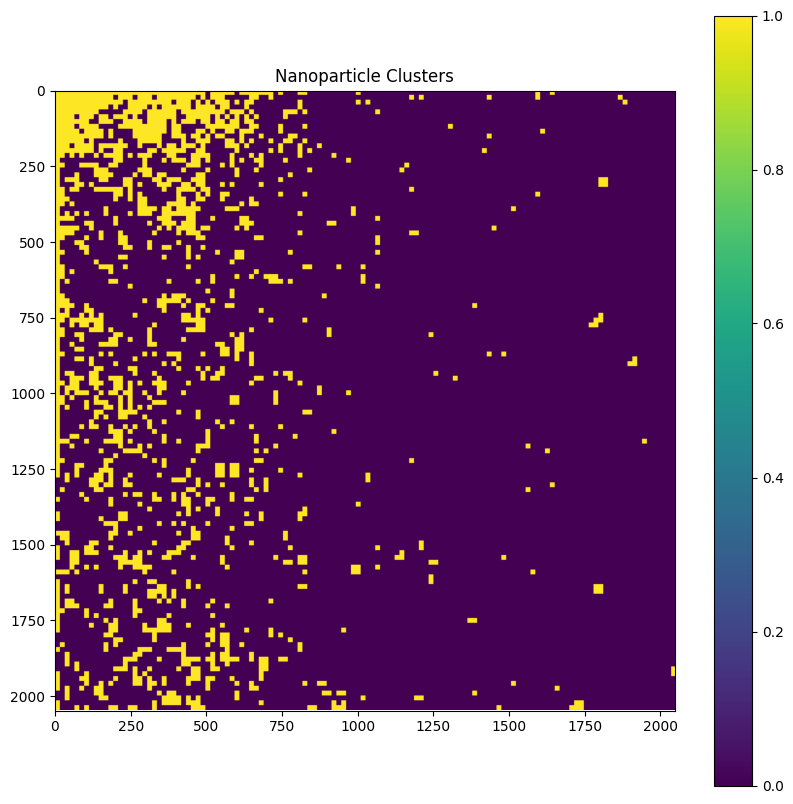

In [13]:
# single gmm with patches

gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_representations)
cluster_labels = gmm.predict(latent_representations)

# Identify unique clusters
unique_clusters = set(cluster_labels)

# Treat -1 as particles (if it exists), otherwise assume the smallest cluster represents particles
if -1 in unique_clusters:
    binary_cluster_labels = [1 if label == -1 else 0 for label in cluster_labels]
else:
    # Assume the smallest cluster represents particles
    particle_group_label = min(unique_clusters, key=list(cluster_labels).count)
    binary_cluster_labels = [1 if label == particle_group_label else 0 for label in cluster_labels]

# Visualize results
sample_img = next(iter(test_loader)).to(device)
clustered_image = visualize_clusters(sample_img[0].cpu(), patch_coordinates, binary_cluster_labels)

In [14]:
# Reshape to match patch layout
H, W = sample_img.shape[2], sample_img.shape[3]  # Get height and width of original image
grid_h = H // patch_size
grid_w = W // patch_size

# Convert cluster labels into a 2D grid matching the patches
cluster_labels_grid = np.array(cluster_labels).reshape(grid_h, grid_w)

In [19]:
# gmm twice
gmm = GaussianMixture(n_components=20, random_state=42, covariance_type="full")
gmm.fit(latent_representations)
cluster_labels = gmm.predict(latent_representations)

original_centroids = gmm.means_

gmm_2 = GaussianMixture(n_components=2, random_state=42, covariance_type="full")
gmm_2.fit(original_centroids)
centroid_labels = gmm_2.predict(original_centroids)

# Map the original cluster labels to 2 groups (particle or background)
particle_group_label = max(set(centroid_labels), key=list(centroid_labels).count)
particle_clusters = [i for i, label in enumerate(centroid_labels) if label == particle_group_label]
binary_cluster_labels = [1 if cluster_labels[i] in particle_clusters else 0 for i in range(len(cluster_labels))]

Visualizing First Clustering Layers
Unique cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


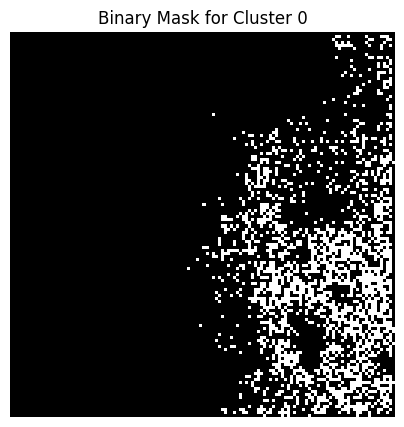

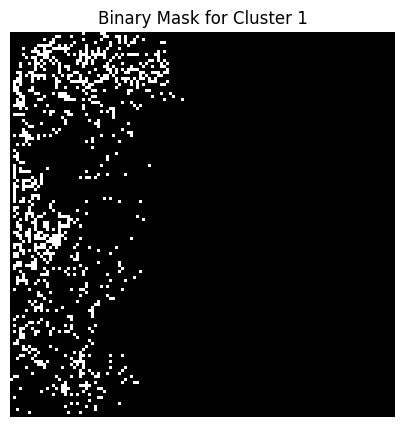

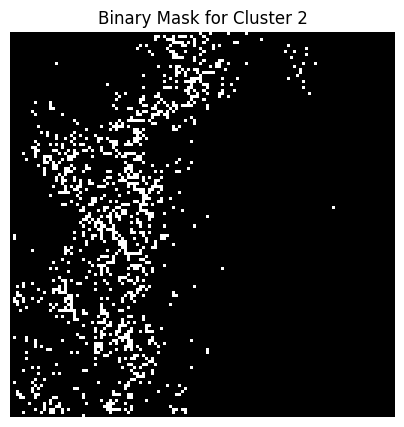

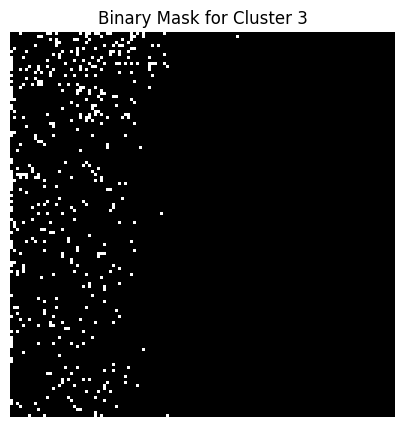

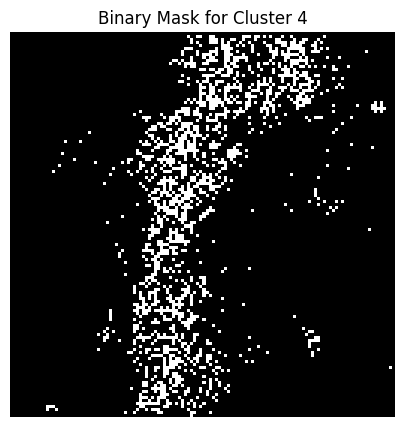

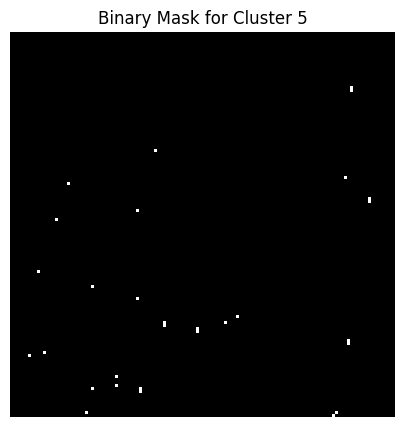

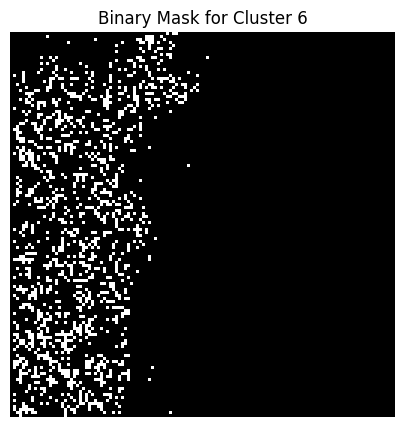

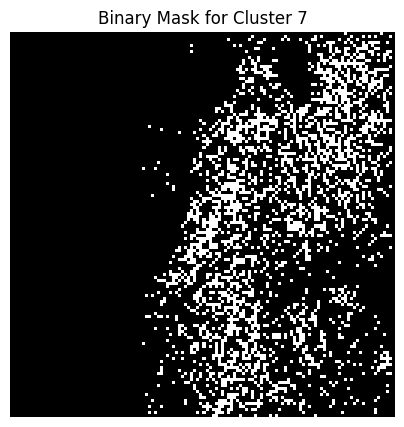

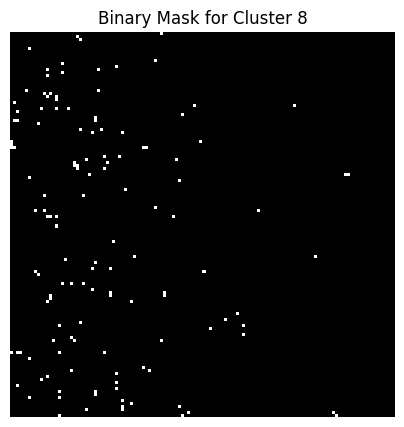

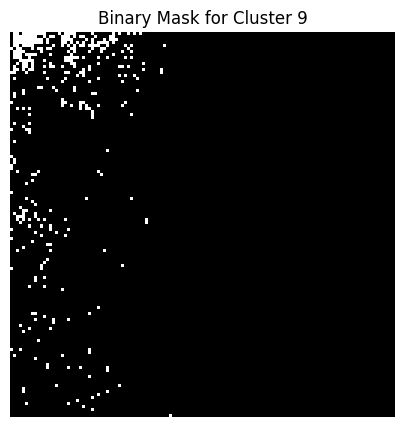

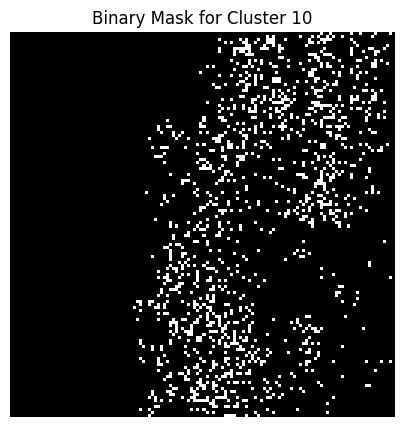

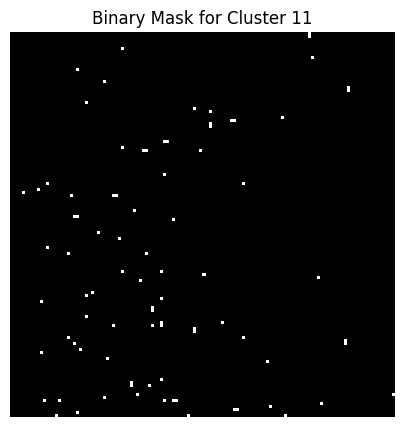

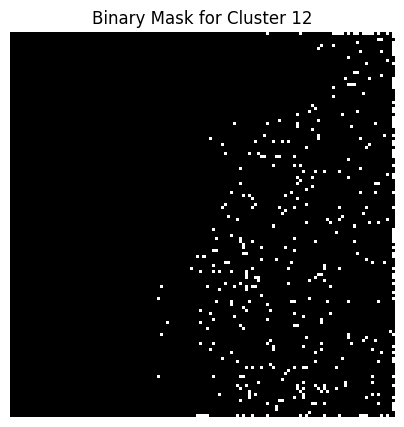

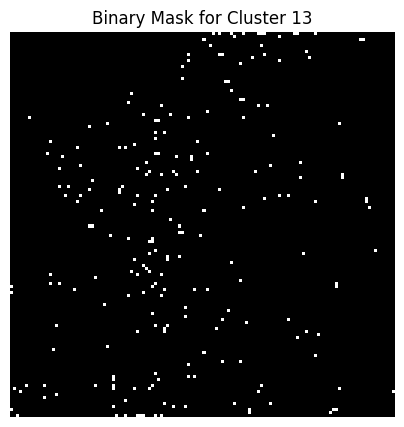

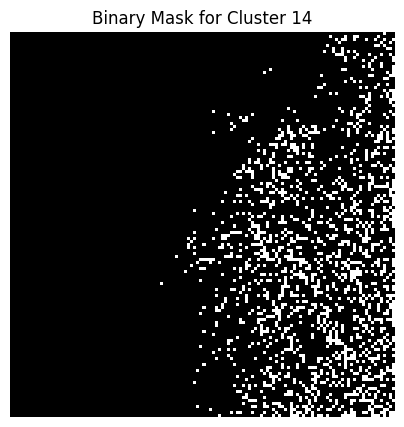

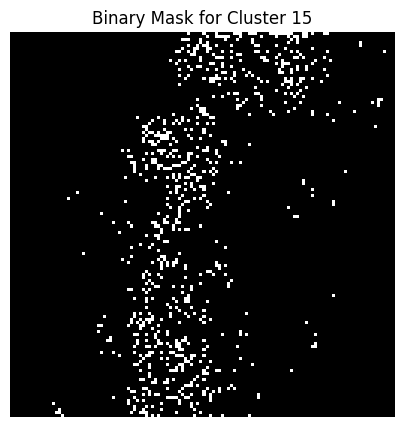

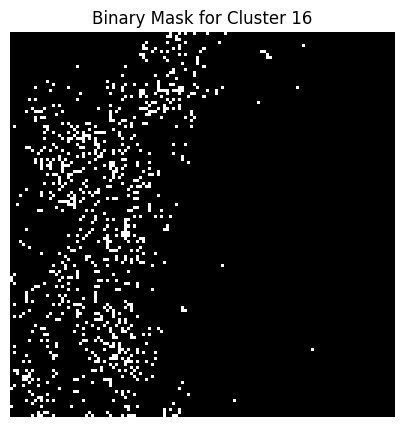

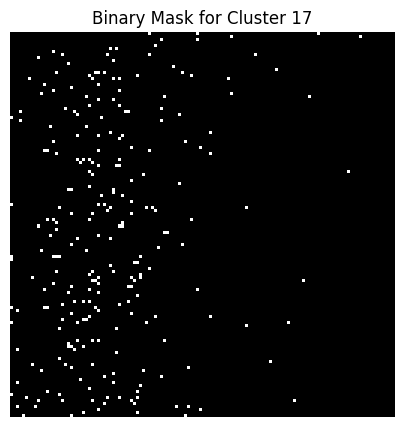

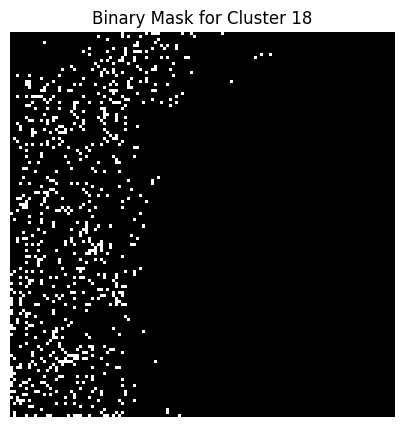

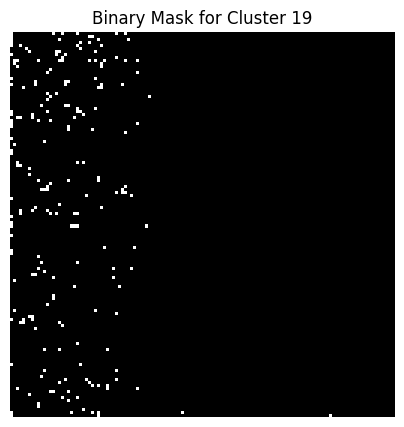

In [20]:
# look at first cluster layers
cluster_labels_grid = np.array(cluster_labels).reshape(grid_h, grid_w)

print("Visualizing First Clustering Layers")
visualize_binary_clusters(cluster_labels_grid)

Visualizing Second Clustering Layers
Unique cluster labels: [0 1]


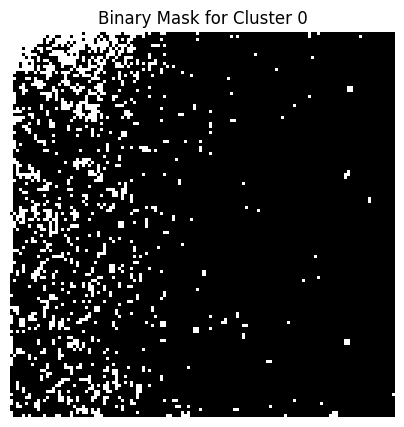

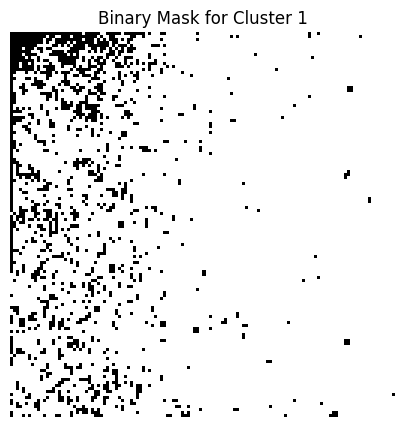

In [21]:
# look at second cluster layers individually
binary_cluster_labels_grid = np.array(binary_cluster_labels).reshape(grid_h, grid_w)

print("Visualizing Second Clustering Layers")
visualize_binary_clusters(binary_cluster_labels_grid)

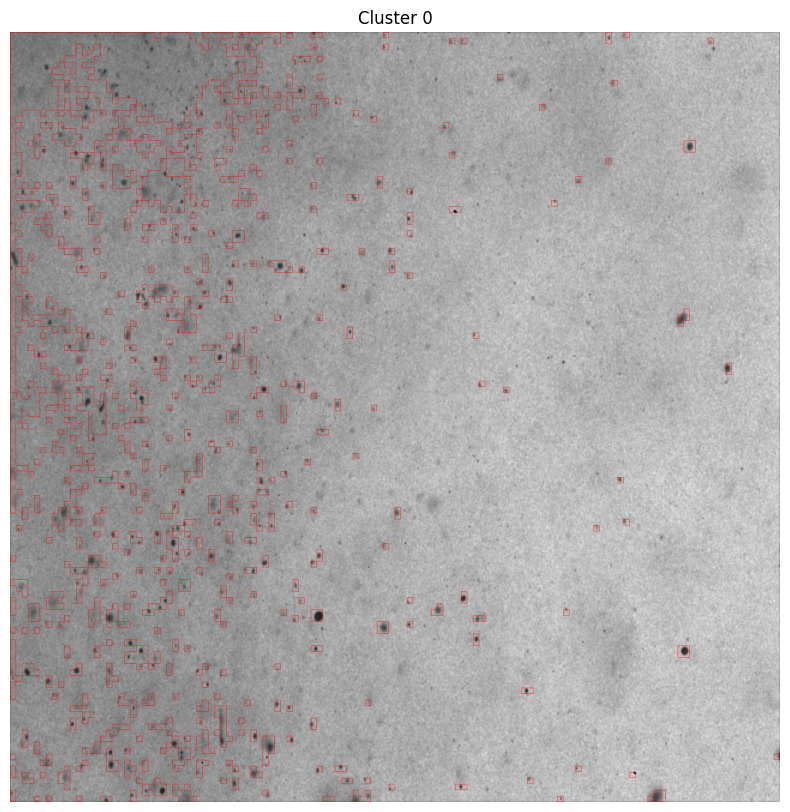

In [24]:
plot_cluster_contours(
    sample_img[0],
    binary_cluster_labels_grid=binary_cluster_labels_grid,
    cluster_id=0,
)

In [ ]:
#save for something else

import matplotlib.pyplot as plt

# Get latent space feature maps (B, 512, H', W')
with torch.no_grad():
    latent_space = autoencoder.encode(test_loader)

# Select one image from the batch
feature_maps = latent_space[0].cpu().detach().numpy()  # Shape: (512, H', W')

# Plot 16 random feature maps
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[i], cmap="gray")
    ax.set_title(f"Feature Map {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()